In [1]:
packages <- c("ggplot2", "dplyr", "patchwork")
for (pkg in packages) {
    suppressPackageStartupMessages(
        suppressWarnings(
            library(
                pkg,
                character.only = TRUE,
                quietly = TRUE,
                warn.conflicts = FALSE
            )
        )
    )
}

In [2]:
umap_file_path <- file.path(
    "../../../3.generate_umaps/results/UMAP/CP_scDINO_umap.parquet"
)
mAP_file_path <- file.path(
    "../../../4.mAP_analysis/data/mAP/mAP_scores_CP_scDINO.parquet"
)
cell_count_file_path <- file.path(
    "../../../2.cell_tracks_data/data/combined_stats.parquet"
)

# final figure path 
figures_path <- file.path("../figures")
if (!dir.exists(figures_path)) {
    dir.create(figures_path, recursive = TRUE)
}
final_figure_path <- file.path(
    figures_path,
    "metric_v_time_plot.png"
)

umap_df <- arrow::read_parquet(umap_file_path)
mAP_df <- arrow::read_parquet(mAP_file_path)
cell_count_df <- arrow::read_parquet(cell_count_file_path)


In [3]:
color_pallete_for_dose <- c(
    "0.0" = "#57F2F2",
    "0.61" = "#63D6D6",
    "1.22" = "#65BABA",
    "2.44" = "#68A3A3",
    "4.88" = "#668A8A",
    "9.77" = "#5E7070",
    "19.53" = "#4B5757",
    "39.06" = "#2F3D3D",
    "78.13" = "#182424",
    "156.25" = "#030A0A"
)

In [4]:
umap_df$Metadata_dose <- as.character(umap_df$Metadata_dose)
umap_df$Metadata_dose <- factor(
    umap_df$Metadata_dose, 
    levels = c(
        '0.0',
        '0.61',
        '1.22',
        '2.44',
        '4.88',
        '9.77',
        '19.53',
        '39.06',
        '78.13',
        '156.25'
    )
)

mAP_df$Metadata_dose <- as.character(mAP_df$Metadata_dose)
mAP_df$Metadata_dose <- factor(
    mAP_df$Metadata_dose, 
    levels = c(
        '0.0',
        '0.61',
        '1.22',
        '2.44',
        '4.88',
        '9.77',
        '19.53',
        '39.06',
        '78.13',
        '156.25'
    )
)
umap_df$Metadata_Time <- as.numeric(umap_df$Metadata_Time) * 30
mAP_df$Metadata_Time <- as.numeric(mAP_df$Metadata_Time) * 30
cell_count_df$Metadata_time <- as.numeric(cell_count_df$Metadata_time) * 30

In [5]:
font_size <- 24
plot_themes <- (
    theme_bw()
    + theme(
        legend.position = "bottom",
        legend.text = element_text(size = font_size),
        legend.title = element_text(size = font_size),
        axis.title.x = element_text(size = font_size),
        axis.text.x = element_text(size = font_size),
        axis.title.y = element_text(size = font_size),
        axis.text.y = element_text(size = font_size),
        strip.text = element_text(size = font_size),
    )
    
    
)

## Plot mAP over time

In [6]:
# replace shuffle values with Shuffled and Not Shuffled
mAP_df$Shuffle <- gsub(
    "True", 
    "Shuffled", 
    mAP_df$Shuffle
)
mAP_df$Shuffle <- gsub(
    "False", 
    "Not Shuffled", 
    mAP_df$Shuffle
)

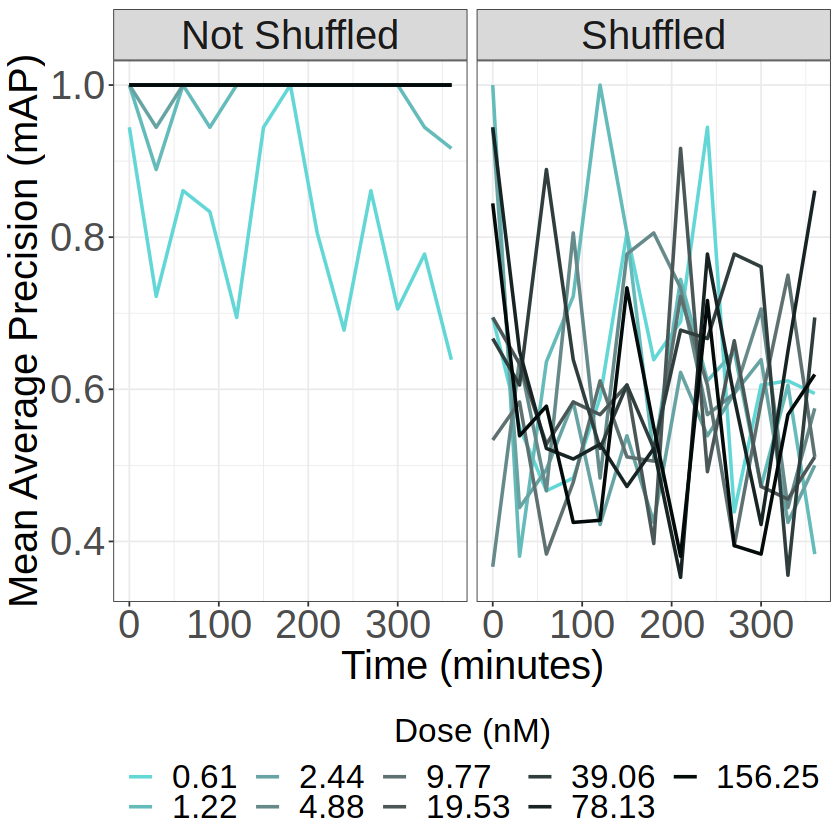

In [7]:
mAP_plot <- (
    ggplot(data = mAP_df, aes(x = Metadata_Time, y = mean_average_precision))
    + geom_line(aes(color = Metadata_dose), linewidth = 1)
    + facet_wrap(Shuffle~.)
    + scale_color_manual(values = color_pallete_for_dose)
    + labs(
        x = "Time (minutes)",
        y = "Mean Average Precision (mAP)",
        color = "Dose (nM)",
    )
    
    # change the legend title
    + guides(
        color = guide_legend(
            override.aes = list(size = 5),
            title.position = "top",
            title.hjust = 0.5,
            title.theme = element_text(size = font_size - 4 ),
            label.theme = element_text(size = font_size - 4),
            nrow = 2,
        ))
    + plot_themes

)
mAP_plot

## Plot UMAP over time

### UMAP 0 vs UMAP 1 colored by time

In [8]:
umap_df$Metadata_dose_w_unit <- paste0(
    umap_df$Metadata_dose, 
    " nM"
)
umap_df$Metadata_dose_w_unit <- as.character(umap_df$Metadata_dose_w_unit)
umap_df$Metadata_dose_w_unit <- factor(
    umap_df$Metadata_dose_w_unit, 
    levels = c(
        '0.0 nM',
        '0.61 nM',
        '1.22 nM',
        '2.44 nM',
        '4.88 nM',
        '9.77 nM',
        '19.53 nM',
        '39.06 nM',
        '78.13 nM',
        '156.25 nM'
    )
)

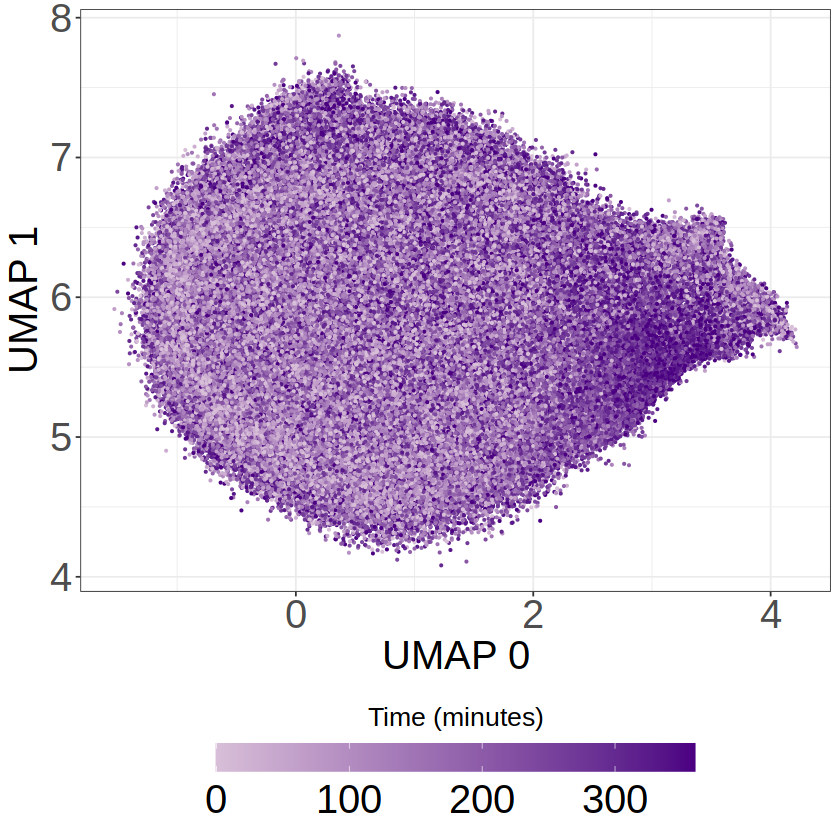

In [9]:
umap_plot <- (
    ggplot(data = umap_df, aes(x = UMAP_0, y = UMAP_1))
    + geom_point(aes(color = Metadata_Time), size = 0.5)
    + scale_color_gradient(
    low = "#D8BFD8",  # Light purple (Thistle)
    high = "#4B0082"  # Dark purple (Indigo)
    )
    + labs(
        x = "UMAP 0",
        y = "UMAP 1",
        color = "Time (minutes)",
    )
    # make the legend title on top
    + guides(
        color = guide_colorbar(
            title.position = "top",
            title.hjust = 0.5,
            title.theme = element_text(size = 16),
            # make the legend longer 
            barwidth = 20,
        ))
    + plot_themes

)
umap_plot

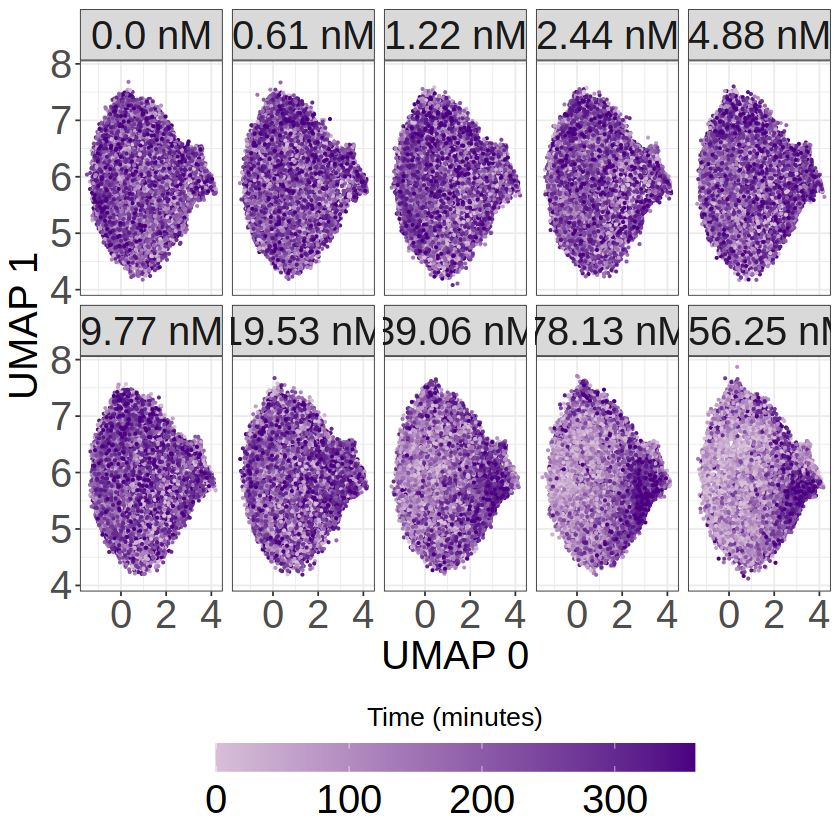

In [10]:
umap_df$Metadata_Time <- as.numeric(umap_df$Metadata_Time)
umap_plot_facet <- (
    ggplot(data = umap_df, aes(x = UMAP_0, y = UMAP_1))
    + geom_point(aes(color = Metadata_Time), size = 0.5)
    + scale_color_gradient(
    low = "#D8BFD8",  # Light purple (Thistle)
    high = "#4B0082"  # Dark purple (Indigo)
    )
    + labs(
        x = "UMAP 0",
        y = "UMAP 1",
        color = "Time (minutes)",
    )
    + facet_wrap(Metadata_dose_w_unit~., nrow = 2)
    + guides(
        color = guide_colorbar(
            title.position = "top",
            title.hjust = 0.5,
            title.theme = element_text(size = 16),
            # make the legend longer 
            barwidth = 20,
        ))
    + plot_themes
)
umap_plot_facet

### UMAP 0 vs Time colored by dose

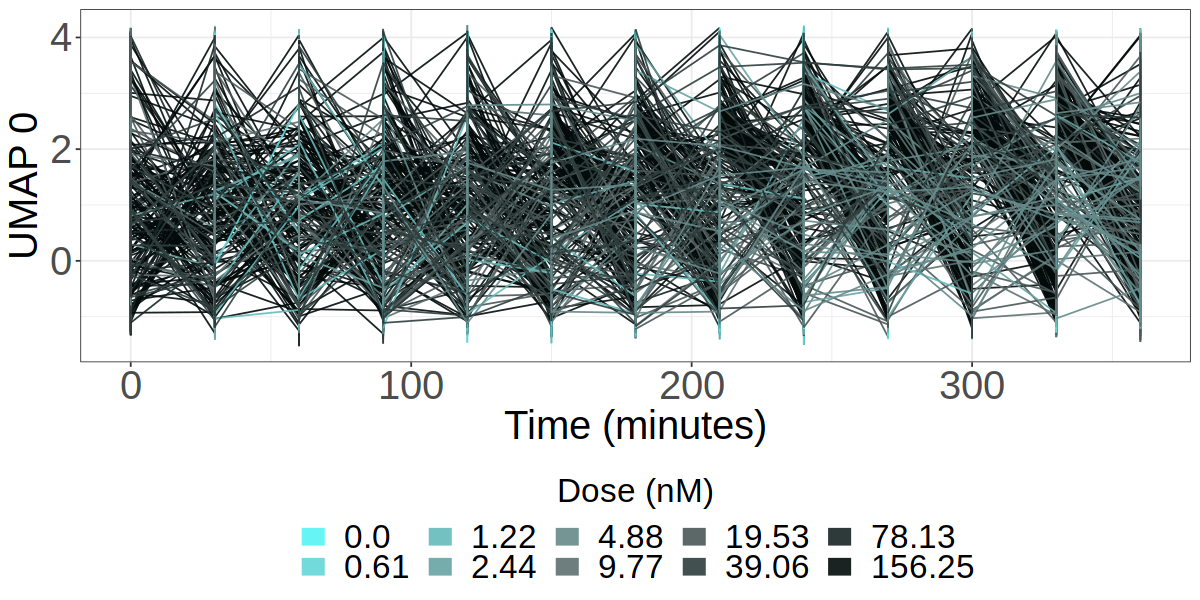

In [11]:
width <- 10
height <- 5
options(repr.plot.width=width, repr.plot.height=height)
umap_0_v_time <- (
    ggplot(data = umap_df, aes(x = Metadata_Time, y = UMAP_0))
    + geom_line(aes(group = Metadata_track_id, color = Metadata_dose), alpha = 0.9, linewidth = 0.5)
    + scale_color_manual(values = color_pallete_for_dose)
    + labs(
        x = "Time (minutes)",
        y = "UMAP 0",
        color = "Dose (nM)",
    )
    + guides(
        color = guide_legend(
            override.aes = list(linewidth = 5),
            
            title.position = "top",
            title.hjust = 0.5,
            title.theme = element_text(size = font_size - 4 ),
            label.theme = element_text(size = font_size - 4),
            nrow = 2,
        ))
    + plot_themes
    

)
umap_0_v_time

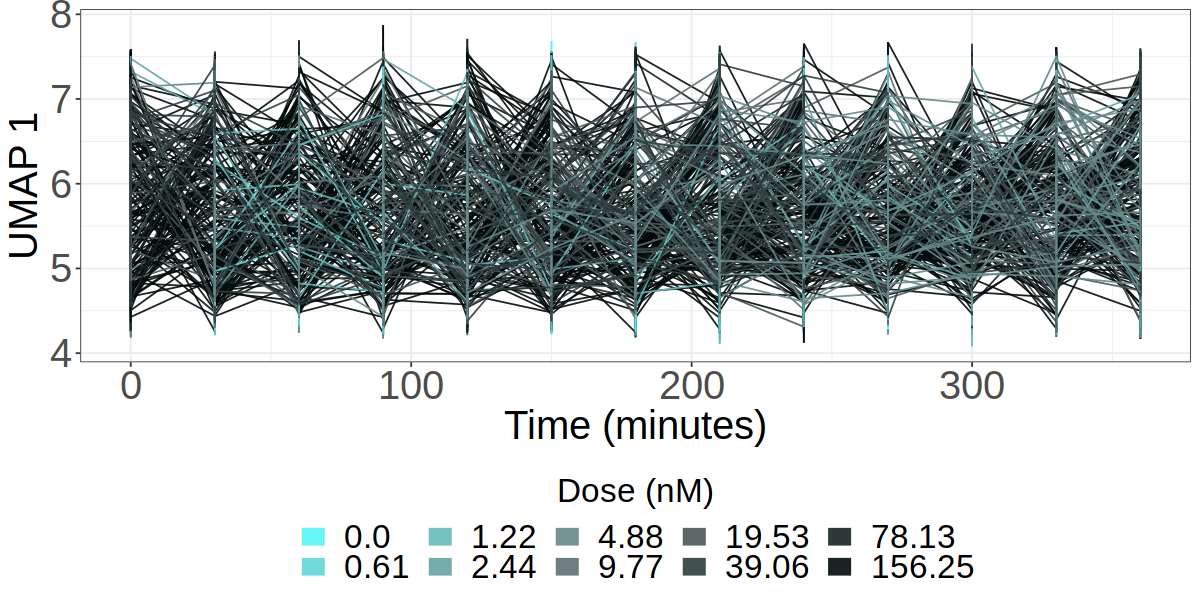

In [12]:
umap_1_v_time <- (
    ggplot(data = umap_df, aes(x = Metadata_Time, y = UMAP_1))
    + geom_line(aes(group = Metadata_track_id, color = Metadata_dose), alpha = 0.9, linewidth = 0.5)
    + scale_color_manual(values = color_pallete_for_dose)
    + labs(
        x = "Time (minutes)",
        y = "UMAP 1",
        color = "Dose (nM)",
    )
    + guides(
        color = guide_legend(
            override.aes = list(linewidth = 5),
            
            title.position = "top",
            title.hjust = 0.5,
            title.theme = element_text(size = font_size - 4 ),
            label.theme = element_text(size = font_size - 4),
            nrow = 2,
        ))
    + plot_themes

)
umap_1_v_time

## Plot cell count over time

In [13]:
# get the well from the well_fov column, get the first part of the string
# before the underscore and number
cell_count_df$well <- sub("_.*", "", cell_count_df$well_fov)
# map the well to the dose from the mAP_df
well_dose_df <- umap_df %>%
    select(well = Metadata_Well, dose = Metadata_dose) %>%
    distinct()
# map the well to the dose in the cell_count_df
cell_count_df <- cell_count_df %>%
    left_join(well_dose_df, by = "well") 
# rename dose to Metadata_dose
cell_count_df <- cell_count_df %>%
    rename(Metadata_dose = dose) %>%
    rename(Metadata_Well = well) 
cell_count_df$Metadata_dose <- as.character(cell_count_df$Metadata_dose)
cell_count_df$Metadata_dose <- factor(
    cell_count_df$Metadata_dose, 
    levels = c(
        '0.0',
        '0.61',
        '1.22',
        '2.44',
        '4.88',
        '9.77',
        '19.53',
        '39.06',
        '78.13',
        '156.25'
    )
)


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


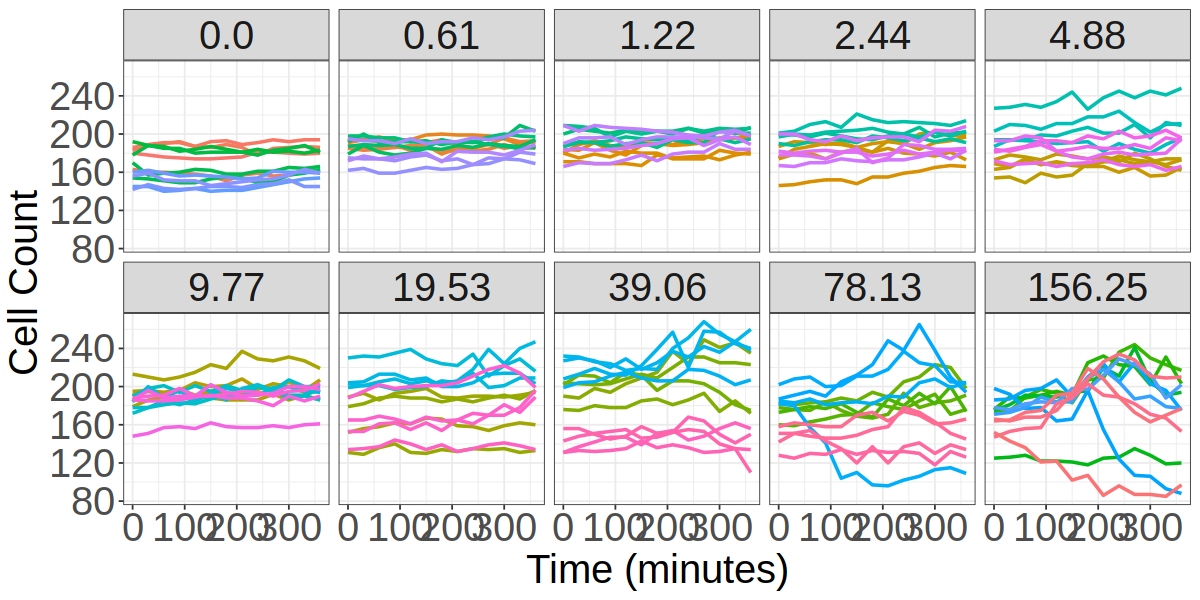

In [14]:
cell_count_v_time_plot <- (
    ggplot(data = cell_count_df, aes(x = Metadata_time, y = total_CP_cells))
    + geom_line(aes(color = well_fov), size = 1)
    
    + facet_wrap(Metadata_dose~. ,nrow = 2)
    + labs(
        x = "Time (minutes)",
        y = "Cell Count",
        color = "Dose (nM)",
    )
    + plot_themes
    + theme(legend.position = "none")

)
cell_count_v_time_plot

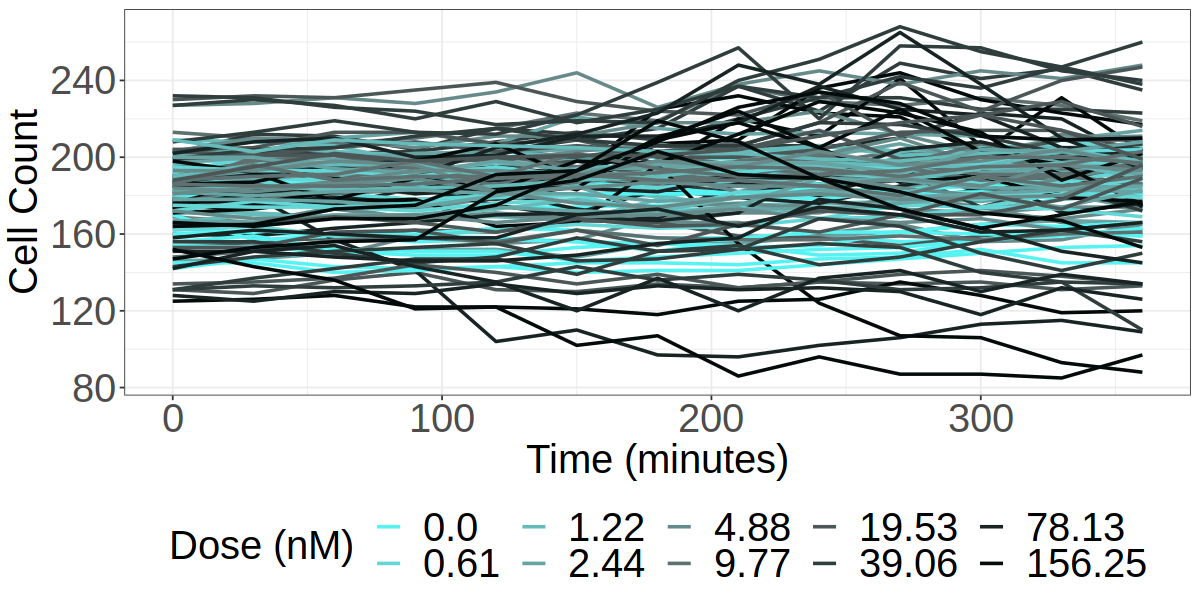

In [15]:
cell_count_v_time_plot_colored_by_dose <- (
    ggplot(data = cell_count_df, aes(x = Metadata_time, y = total_CP_cells))
    + geom_line(aes(group = well_fov,color = Metadata_dose), size = 1)
    + scale_color_manual(values = color_pallete_for_dose)
    + labs(
        x = "Time (minutes)",
        y = "Cell Count",
        color = "Dose (nM)",
    )
    + plot_themes

)
cell_count_v_time_plot_colored_by_dose

## Assemble all plots into a single figure

In [16]:
mAP_plot <- mAP_plot + theme(legend.position = "none")
cell_count_v_time_plot_colored_by_dose <- cell_count_v_time_plot_colored_by_dose + theme(legend.position = "none")

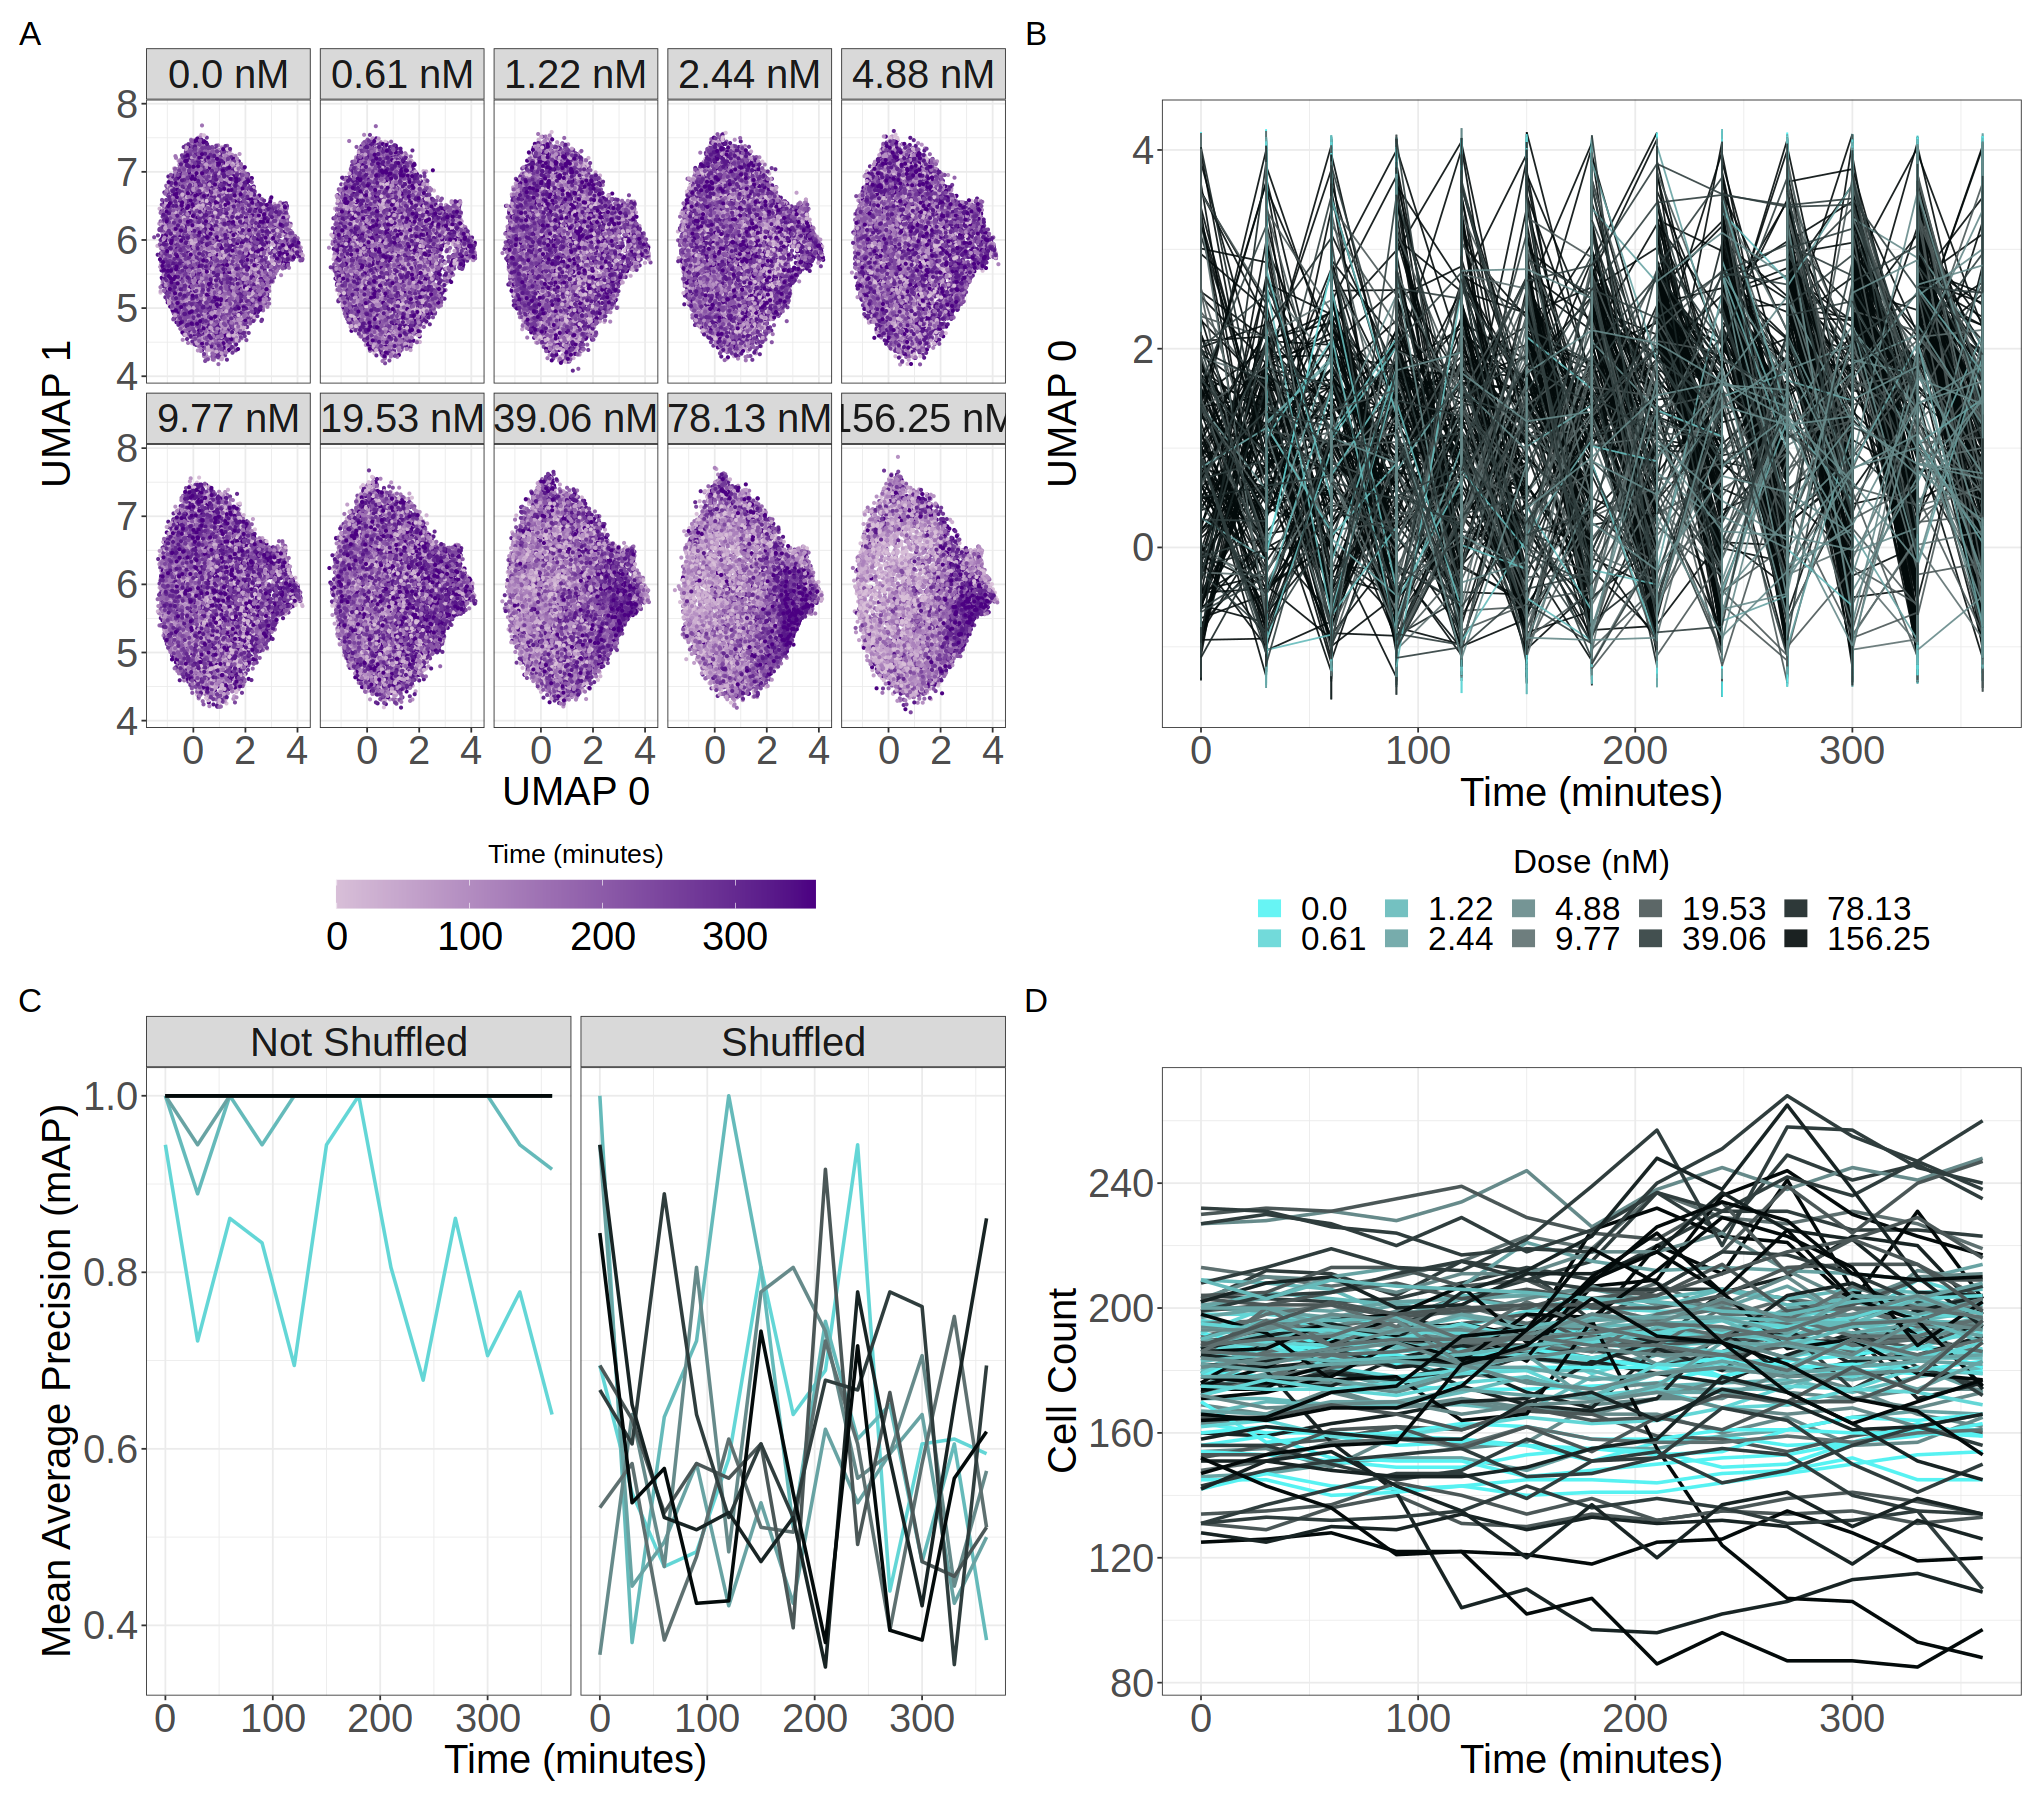

In [17]:
width <- 17
height <- 15
options(repr.plot.width=width, repr.plot.height=height)
layout <- c(
    area(t=1, b=1, l=1, r=2), # A
    area(t=1, b=1, l=3, r=4), # B
    area(t=2, b=2, l=1, r=2), # C
    area(t=2, b=2, l=3, r=4) # D
)
metric_v_time_final_plot <- (
    umap_plot_facet
    + umap_0_v_time
    + mAP_plot
    
    + cell_count_v_time_plot_colored_by_dose
    
    + plot_layout(design = layout, widths = c(0.6, 1))
    # make bottom plot not align
    + plot_annotation(tag_levels = 'A') & theme(plot.tag = element_text(size = 20))
)
ggsave(
    filename = final_figure_path,
    plot = metric_v_time_final_plot,
    width = width,
    height = height,
    dpi = 600
)
metric_v_time_final_plot